In [1]:
# LSTM modelis Bitcoin kainai prognozuoti
#
# Šiame notebook implementuosime LSTM (Long Short-Term Memory) modelį, kuris yra pritaikytas laiko eilučių duomenims.

In [2]:
# Reikalingų bibliotekų importavimas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import requests
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Funkcija duomenims gauti tiesiai iš Binance API
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"

def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
    if end_time is None:
        end_time = datetime.now()
    if start_time is None:
        start_time = end_time - timedelta(days=365)  # 14 dienų

    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    all_klines = []
    current_start = start_ts

    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        try:
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            klines = response.json()
            if not klines:
                break
            all_klines.extend(klines)
            current_start = int(klines[-1][0]) + 1
            time.sleep(0.5)
        except Exception as e:
            print(f"Klaida gaunant duomenis: {str(e)}")
            time.sleep(2)
    if all_klines:
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df = pd.DataFrame(all_klines, columns=columns)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        print(f"Sėkmingai gauta {len(df)} įrašų")
        return df
    return None

# Gauname metų su 15min intervalu
end_time = datetime.now()
start_time = end_time - timedelta(days=365)
print(f"Gaunami duomenys nuo {start_time} iki {end_time}...")
df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)
if df is not None:
    display(df.head())
else:
    raise Exception("Nepavyko gauti duomenų, tęsti negalima.")

Gaunami duomenys nuo 2024-05-23 04:29:50.233844 iki 2025-05-23 04:29:50.233844...
Sėkmingai gauta 35040 įrašų


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2024-05-23 01:30:00,69520.58,69626.87,69470.82,69550.02,215.53071,1716428699999,14992323.19123790,9540,133.36336000,9276234.14263770,0
1,2024-05-23 01:45:00,69550.01,69550.02,69483.15,69483.16,90.53286,1716429599999,6292928.72042030,4900,33.73308000,2344664.51372660,0
2,2024-05-23 02:00:00,69483.15,69561.98,69470.26,69540.68,98.17671,1716430499999,6825341.79444770,6659,46.16900000,3209569.59150510,0
3,2024-05-23 02:15:00,69540.68,69562.00,69458.24,69467.57,89.72920,1716431399999,6238454.19918030,4834,32.41618000,2253889.65967380,0
4,2024-05-23 02:30:00,69467.57,69520.00,69430.00,69462.00,85.58983,1716432299999,5945733.12771760,5511,42.16926000,2929342.14844090,0


In [4]:
# Duomenų paruošimas
df = df.sort_values('time')
print(f"Duomenų intervalas: nuo {df['time'].min()} iki {df['time'].max()}")
print(f"Įrašų skaičius: {len(df)}")
if df.isnull().sum().sum() > 0:
    print("Užpildome trūkstamas reikšmes...")
    df = df.fillna(method='ffill')

Duomenų intervalas: nuo 2024-05-23 01:30:00 iki 2025-05-23 01:15:00
Įrašų skaičius: 35040


In [5]:
# Duomenų paruošimas
df = df.sort_values('time')
print(f"Duomenų intervalas: nuo {df['time'].min()} iki {df['time'].max()}")
print(f"Įrašų skaičius: {len(df)}")
if df.isnull().sum().sum() > 0:
    print("Užpildome trūkstamas reikšmes...")
    df = df.fillna(method='ffill')

Duomenų intervalas: nuo 2024-05-23 01:30:00 iki 2025-05-23 01:15:00
Įrašų skaičius: 35040


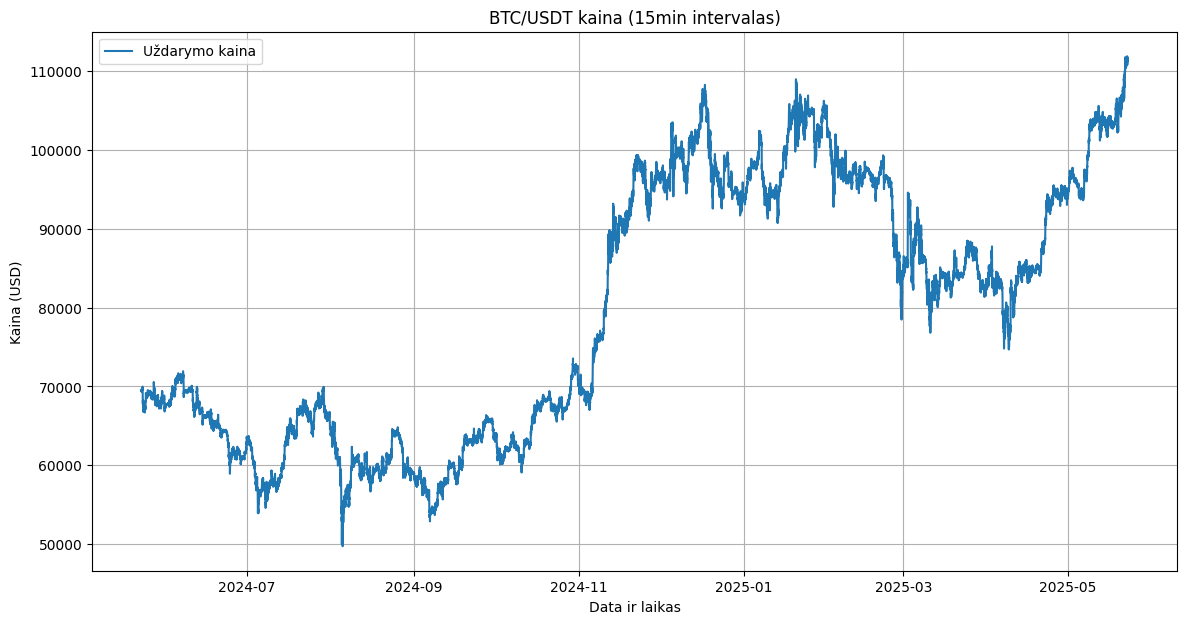

In [6]:
# Vizualizacija
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Uždarymo kaina')
plt.title('BTC/USDT kaina (15min intervalas)')
plt.xlabel('Data ir laikas')
plt.ylabel('Kaina (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Normalizavimas
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
df_normalized.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2024-05-23 01:30:00,0.318308,0.313633,0.326583,0.318782,0.022494,1716428699999,14992323.19123790,9540,133.36336000,9276234.14263770,0
1,2024-05-23 01:45:00,0.318782,0.312388,0.326780,0.317706,0.008798,1716429599999,6292928.72042030,4900,33.73308000,2344664.51372660,0
2,2024-05-23 02:00:00,0.317706,0.312582,0.326574,0.318632,0.009635,1716430499999,6825341.79444770,6659,46.16900000,3209569.59150510,0
3,2024-05-23 02:15:00,0.318632,0.312582,0.326382,0.317456,0.008710,1716431399999,6238454.19918030,4834,32.41618000,2253889.65967380,0
4,2024-05-23 02:30:00,0.317456,0.311901,0.325932,0.317366,0.008256,1716432299999,5945733.12771760,5511,42.16926000,2929342.14844090,0


In [8]:
# Sliding window sekų kūrimas
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 10
target_column = 'close'
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35030, 10, 5), y shape: (35030,)


In [9]:
# Duomenų padalijimas į mokymo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (28024, 10, 5), X_test shape: (7006, 10, 5)
y_train shape: (28024,), y_test shape: (7006,)


In [10]:
# LSTM modelio kūrimas
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_lstm_model(input_shape)
lstm_model.summary()

d:\CA_BTC\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Apibrėžiame callback funkcijas ir apmokome modelį
os.makedirs('../../models', exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(
        filepath='../../models/lstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

batch_size = 32
epochs = 50

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
875/876 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081

876/876 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0081 - val_loss: 7.2959e-05
Epoch 2/50
875/876 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5037e-04

OSError: [Errno 22] Unable to synchronously create file (unable to open file: name = '../../models/lstm_model.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

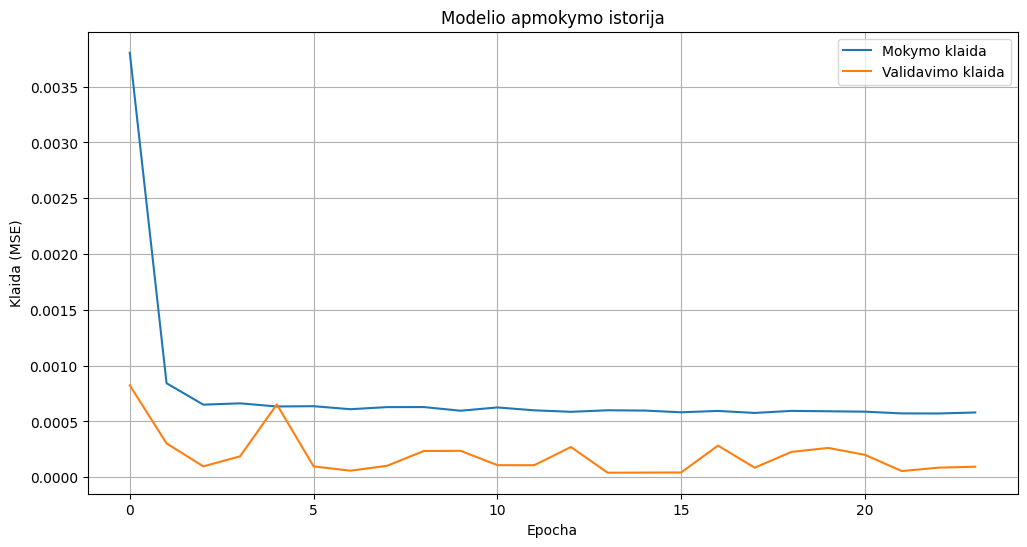

In [ ]:
# Apmokymo istorijos vizualizacija
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('Modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prognozės ir atstatymas į originalią skalę
y_pred = lstm_model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, target_idx=3):
    dummy = np.zeros((len(predictions), len(columns_to_normalize)))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = columns_to_normalize.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


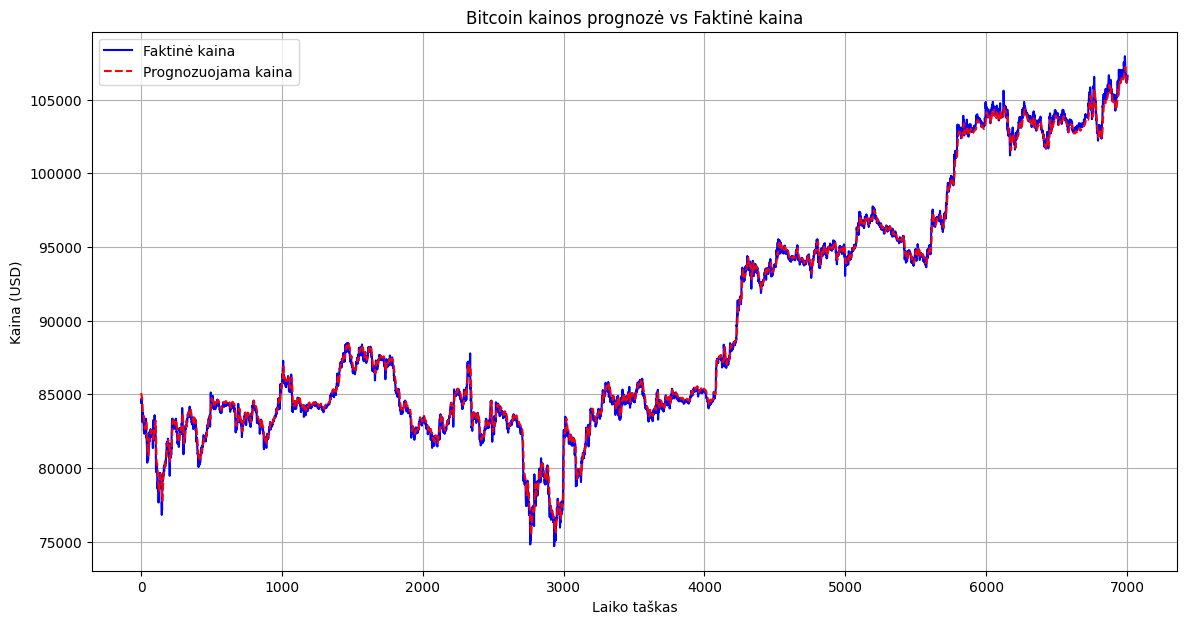

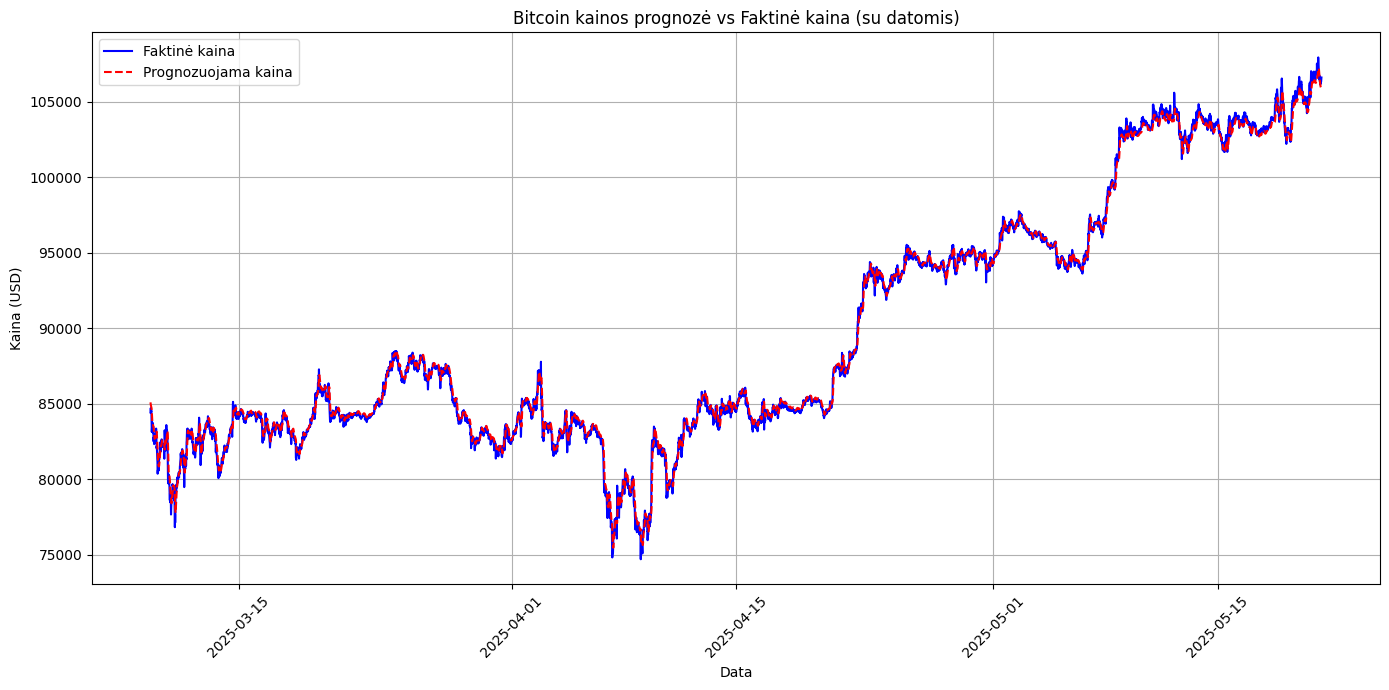

In [ ]:
# Vizualizuojame prognozes
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Faktinė kaina', color='blue')
plt.plot(y_pred_original, label='Prognozuojama kaina', color='red', linestyle='--')
plt.title('Bitcoin kainos prognozė vs Faktinė kaina')
plt.xlabel('Laiko taškas')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Grafiko tobulinimas - parodome prognozių datas
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='Prognozuojama kaina', color='red', linestyle='--')
plt.title('Bitcoin kainos prognozė vs Faktinė kaina (su datomis)')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Metrikų skaičiavimas
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 144103.00
Root Mean Squared Error (RMSE): 379.61
Mean Absolute Error (MAE): 266.93
R² Score: 0.9979
Mean Absolute Percentage Error (MAPE): 0.30%


In [ ]:
# Modelio ir scaler išsaugojimas
import pickle
lstm_model.save('../../models/lstm_model.h5')
with open('../../models/lstm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Modelis ir scaler sėkmingai išsaugoti.")

Modelis ir scaler sėkmingai išsaugoti.
